In [1]:
import sys
sys.path.append("figures_material")
from bnet_viz import render_bnet_graph

art = render_bnet_graph(
    bnet_path="input/networks/test/14.bnet",  # or bnet_text=...
    max_per_row=2,
    max_per_row_output=2,
    order_mode="osci_order",       # "hierarchical_order" | "random_order" | "osci_order"
    osci_top_pct=0.5,
    osci_seed=42,
    x_gap=2, y_gap=2,          # grid spacing
    node_shape="circle",           # "circle" or "ellipse" or anything Graphviz supports
    node_width=1.2, node_height=1.2,
    fontsize=25,
    output_dir="figures_material/toy_network",
    base_name="toy_network_viz",
    fontname="DejaVu Sans"
)
art


{'dot': 'figures_material\\toy_network\\toy_network_viz.dot',
 'png': 'figures_material\\toy_network\\toy_network_viz.png',
 'svg': 'figures_material\\toy_network\\toy_network_viz.svg',
 'positions_json': 'figures_material\\toy_network\\toy_network_viz_positions.json',
 'neato_found': True,
 'order_mode': 'osci_order',
 'max_per_row_internal': 2,
 'max_per_row_input': None,
 'max_per_row_output': 2}

In [1]:
import sys
sys.path.append("src")
import POKE
import util                   # from src/util.py
from copy import deepcopy

# Load parameters (same as CLI main() would do)
params = util.load_yaml("input/params.yaml")

all controllers        : [['A'], ['B']]
relative heights       : [np.int64(2), np.int64(1)]
min controllers        : [['A'], ['B']]
min robust controllers : [['A']]
mechanism data         : {'A': {'graph': <networkx.classes.digraph.DiGraph object at 0x0000013755209D00>, 'controller -> self-driven': [('A', 1), ('B', 1)], 'self-driven -> self-driven': [('A', 1), ('B', 1)], 'self-driven -> target': [('A', 2), ('B', 2)]}}
best controllers       : [['A']]


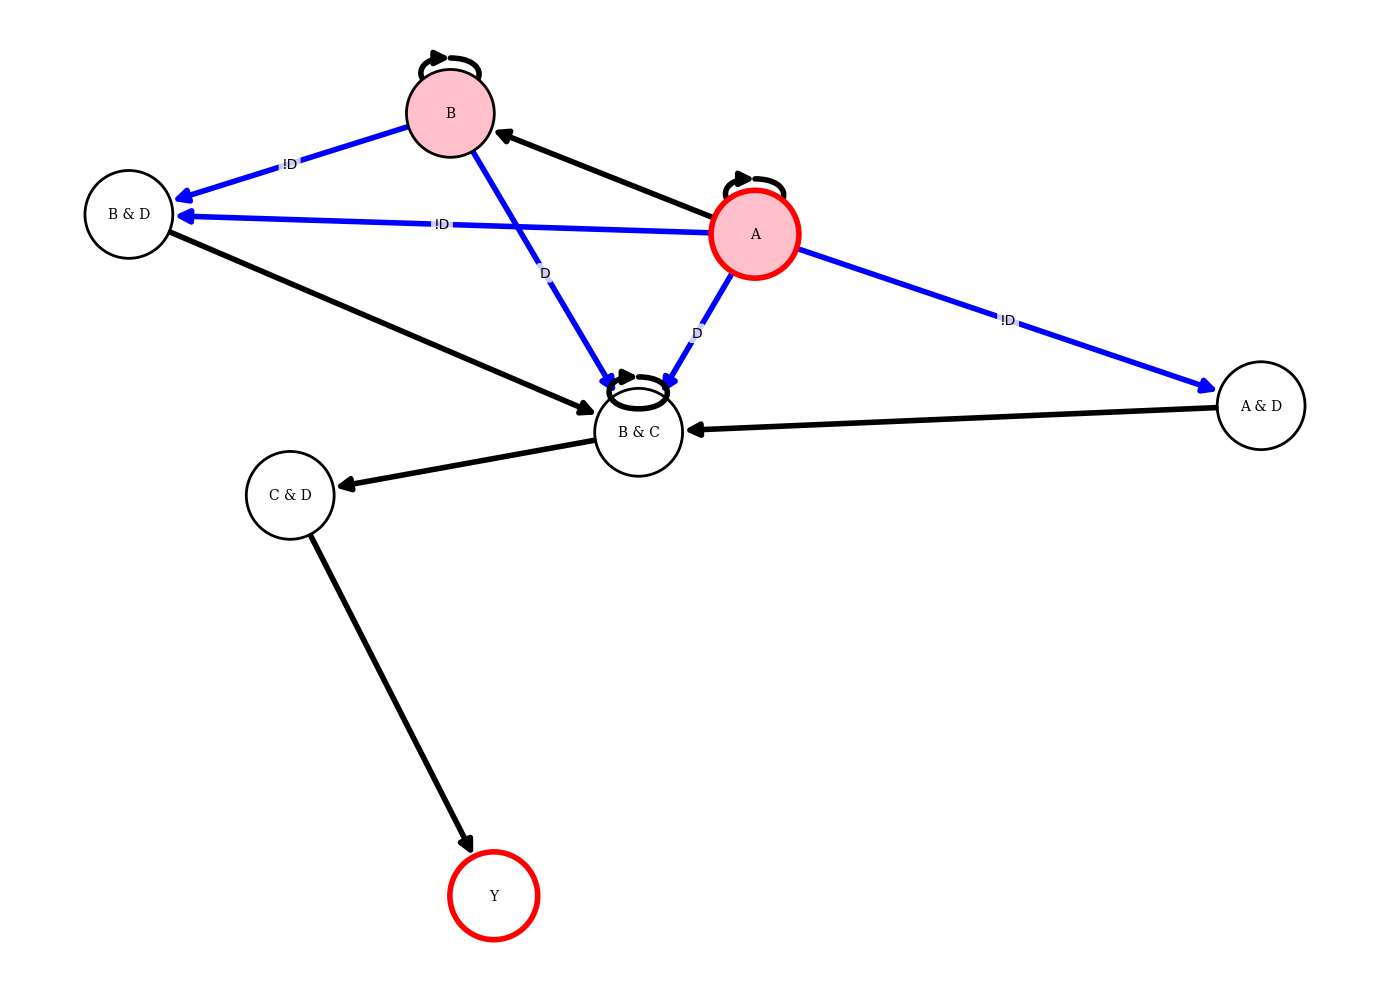

In [2]:
import util, RSC, ensemble, analyze, logic, mechanism

params2 = deepcopy(params)
params2["verbose_poke"] = True
params2["network_file"] = "./input/networks/test/14.bnet"  
params2["target"] = "Y"  # e.g. CPC_IPSC
params2["approx"] = False
params2["analysis_order"] = 2
params2["measure_robustness"] = True
params2["find_mechanism"] = True
params2["controller"] = "A"

# 3) Initialize model once
tstart, F, fn, fn_prev = RSC.init(params2)

# 4) Build terminal logic
terminal_logic = ensemble.terminal_logic_predicate(params2, F)

# 5) Run the core analysis (returns a dict)
results = analyze.robustness_and_mechanism(params2, F, terminal_logic)

# 6) Pretty print or use the dict
util.pretty_print(results)

# 4) if you want plots, recompute the aux stuff (cnt_fns, drives, etc.)
controllers = logic.from_pyEda(terminal_logic)
_, self_driven, drives_self_driven, cnt_fns = analyze.calc_driven_and_self_driven(params2, F, controllers)

# 5) choose what to plot: best controllers or a specific one
to_plot = results["best controllers"] or []
if not to_plot and params2.get("controller"):
    # fall back to the single controller in params if it's in the predicate
    try:
        candidate = logic.str_to_F(params2["controller"])[0]
        if candidate in controllers:
            to_plot = [candidate]
    except Exception:
        pass

# 6) make the plots
for ctrl in to_plot:
    mechanism.find_mechanism(
        params2, F, controllers, ctrl, cnt_fns, drives_self_driven, self_driven,
        plot_it=True  # <- ensures plotting
    )

In [3]:
def print_full_basins(res):
    total = sum(res["counts_full"].values())
    items = sorted(res["counts_full"].items(), key=lambda kv: -kv[1])  # sort by basin size desc
    print(f"Full attractors (with basin sizes), total sims = {total}")
    for k, count in items:
        prob = res["probs_full"][k]
        lam = len(k)
        states = res.get("decoded_full", {}).get(k, [])
        print(f"  λ={lam}  basin={count}/{total}  (prob={prob:.3f})")
        for s in states:
            print("   ", s)

def print_pseudo_basins(res):
    if not res.get("counts_pseudo"):
        print("No pseudo-attractor basins (pseudo_nodes not set).")
        return
    total = sum(res["counts_pseudo"].values())
    items = sorted(res["counts_pseudo"].items(), key=lambda kv: -kv[1])
    print(f"Pseudo-attractors (with basin sizes), total sims = {total}")
    for k, count in items:
        prob = res["probs_pseudo"][k]
        lam = len(k)     # length of the projected cycle
        states = res.get("decoded_pseudo", {}).get(k, [])
        print(f"  λ={lam}  basin={count}/{total}  (prob={prob:.3f})")
        for s in states:
            print("   ", s)

In [4]:
import sys
sys.path.append("src")

from copy import deepcopy
import util
from other_methods import simulate, net
import basin

# 1) Load + merge
params_file = "input/params.yaml"
params_base = util.load_yaml(params_file)

params2 = deepcopy(params_base)
params2["verbose_poke"] = True
params2["network_file"] = "./input/networks/test/14.bnet"

sim_params = simulate.get_sim_params(params2)   # adds clause_bin_size, num_samples, time_steps, update_rule, etc.
params = {**sim_params, **params2}              # merged → use THIS everywhere below

# 2) Build/prepare Net with merged params (NOT params2)
G = net.Net(params)
G.prepare(params)

# 3) Define transient control (names must exist in G.nodeNames)
control = {}  # NOTE: double-check names!

# 4) Run basin calc with merged params
res_orig = basin.basin_under_transient_control(
    params, G, control_dict=control,
    max_steps=1000,
    x0_mode="auto",
    seed=42,
    record_stg=True,
    pseudo_nodes=["Y"]      # also double-check names exist
)

# # 5) Inspect
# print("Total simulations:", sum(res["counts_full"].values()))
# print("\nFull attractors (canonical):")
# for k, v in sorted(res["counts_full"].items(), key=lambda kv: -kv[1]):
#     print(f"  size λ={len(k)}  ->  count={v},  prob={res['probs_full'][k]:.3f}")

# print("\nPseudo-attractor basins:")
# if res["counts_pseudo"]:
#     for k, v in sorted(res["counts_pseudo"].items(), key=lambda kv: -kv[1]):
#         print(f"  cycle_len={len(k)}  pattern={k}  ->  count={v},  prob={res['probs_pseudo'][k]:.3f}")
# else:
#     print("  (none requested)")

print_full_basins(res_orig)
print()
print_pseudo_basins(res_orig)

Full attractors (with basin sizes), total sims = 32
  λ=1  basin=16/32  (prob=0.500)
    {'A': 1, 'B': 1, 'C': 1, 'D': 1, 'Y': 1}
  λ=1  basin=8/32  (prob=0.250)
    {'A': 0, 'B': 0, 'C': 0, 'D': 0, 'Y': 0}
  λ=1  basin=8/32  (prob=0.250)
    {'A': 0, 'B': 1, 'C': 1, 'D': 1, 'Y': 1}

Pseudo-attractors (with basin sizes), total sims = 32
  λ=1  basin=24/32  (prob=0.750)
    {'Y': 1}
  λ=1  basin=8/32  (prob=0.250)
    {'Y': 0}


In [5]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def _unpack_bytes_to_bool(b, n):
    arr = np.frombuffer(b, dtype=np.uint8)
    bits = np.unpackbits(arr)[:n]
    return bits

def _node_order(G):
    names = [nm for nm in G.nodeNames if not nm.startswith(G.not_string)]
    names.sort(key=lambda nm: G.nodeNums[nm])
    return names

def state_bytes_to_code(b, G):
    """Decimal code from internal bit order (idx = node index)."""
    bits = _unpack_bytes_to_bool(b, G.n)
    code = 0
    for nm in _node_order(G):
        idx = G.nodeNums[nm]
        code |= (int(bits[idx]) << idx)
    return code

def state_bytes_to_subset_tuple(b, G, subset):
    bits = _unpack_bytes_to_bool(b, G.n)
    return tuple(int(bits[G.nodeNums[nm]]) for nm in subset)

def build_stg_from_res(res, G, label="code", subset=None):
    """
    label: 'code' | 'subset' | 'none'
      - 'code'   : node label is decimal code
      - 'subset' : node label is tuple of bits over `subset` list
      - 'none'   : nodes are raw bytes (opaque), useful if you only want highlight sets
    subset: list of node names used when label='subset'
    """
    if "edges_union" not in res:
        raise ValueError("edges_union missing. Re-run basin with record_stg=True.")

    edges_raw = res["edges_union"]
    Gs = nx.DiGraph()

    # choose node label function
    if label == "code":
        lab = lambda b: state_bytes_to_code(b, G)
    elif label == "subset":
        if not subset:
            raise ValueError("subset must be provided when label='subset'")
        lab = lambda b: state_bytes_to_subset_tuple(b, G, subset)
    elif label == "none":
        lab = lambda b: b
    else:
        raise ValueError("label must be 'code', 'subset', or 'none'")

    for u,v in edges_raw:
        Gs.add_edge(lab(u), lab(v))
    return Gs


def attractor_node_labels(res, G, label="code", subset=None):
    """
    Return a set of node labels that are part of any attractor in `res`
    using the same labeling scheme as the STG.
    """
    if label == "code":
        lab = lambda b: state_bytes_to_code(b, G)
    elif label == "subset":
        lab = lambda b: state_bytes_to_subset_tuple(b, G, subset)
    elif label == "none":
        lab = lambda b: b
    else:
        raise ValueError("label must be 'code', 'subset', or 'none'")

    S = set()
    for key in res["counts_full"].keys():  # each key is a tuple of packed states (the cycle)
        for b in key:
            S.add(lab(b))
    return S


In [6]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def _normalize_box(pos):
    xs = np.array([p[0] for p in pos.values()])
    ys = np.array([p[1] for p in pos.values()])
    w = xs.max() - xs.min() if xs.max() > xs.min() else 1.0
    h = ys.max() - ys.min() if ys.max() > ys.min() else 1.0
    out = {}
    for n,(x,y) in pos.items():
        out[n] = ((x - xs.min())/w, (y - ys.min())/h)
    return out

import networkx as nx
import numpy as np

def layered_manual_tri(G, layer_gap=8.0, node_gap=6.0, dx=3.0, dy=5.0):
    """
    Manual 'triple-stagger' layout for a DiGraph/STG.
    For each layer, nodes are placed as repeating triples:
      (x, y+dy), (x+dx, y), (x+dx, y-dy)
    Parameters
    ----------
    layer_gap : vertical distance between layers
    node_gap  : horizontal gap between successive triples
    dx        : horizontal offset inside a triple
    dy        : vertical offset inside a triple
    """
    if not G.is_directed():
        raise ValueError("layered_manual_tri expects a DiGraph")

    # Collapse SCCs to DAG → assign layer by longest path
    sccs = list(nx.strongly_connected_components(G))
    comp_id = {n: i for i, comp in enumerate(sccs) for n in comp}
    C = nx.condensation(G, sccs)  # DAG
    topo = list(nx.topological_sort(C))
    depth = {c: 0 for c in C.nodes()}
    for c in topo:
        for v in C.successors(c):
            depth[v] = max(depth[v], depth[c] + 1)

    # Group nodes by layer
    layers = {}
    for n in G.nodes():
        l = depth[comp_id[n]]
        layers.setdefault(l, []).append(n)

    pos = {}
    for l, nodes in layers.items():
        nodes = sorted(nodes, key=str)  # deterministic order
        base_y = -l * layer_gap

        # number of triple-columns for centering
        cols = int(np.ceil(len(nodes) / 3))
        # center the layer around x=0
        x0 = -0.5 * ((cols - 1) * (dx + node_gap))

        for i, n in enumerate(nodes):
            col = i // 3
            slot = i % 3
            x_base = x0 + col * (dx + node_gap)
            if slot == 0:
                x, y = x_base,               base_y + dy
            elif slot == 1:
                x, y = x_base + dx,          base_y
            else:  # slot == 2
                x, y = x_base + dx,          base_y - dy
            pos[n] = (x, y)

    return pos


def component_grid_layout(G, cell_size=10.0, gap=6.0,
                          inner="kamada_kawai", k=0.6, iterations=200, seed=0):
    """
    Place each weakly-connected component in its own grid cell.
    - cell_size: side length of each component's box (world units)
    - gap: empty space between component boxes
    - inner: 'spring' | 'kamada_kawai'  (layout used inside a component)
    """
    # choose components for DiGraph; for Graph, use connected_components
    comps = list(nx.weakly_connected_components(G)) if G.is_directed() else list(nx.connected_components(G))
    comps = sorted(comps, key=len, reverse=True)

    # grid size for components
    C = len(comps)
    cols = int(np.ceil(np.sqrt(C)))
    rows = int(np.ceil(C / cols))

    pos_global = {}
    for idx, nodes in enumerate(comps):
        H = G.subgraph(nodes).copy()

        pos_local = layered_manual_tri(H, layer_gap=12.0, node_gap=10.0, dx=15.0, dy=10.0)
        # normalize to [0,1]x[0,1] then scale to cell box
        pos_local = _normalize_box(pos_local)
        for n in H.nodes():
            x, y = pos_local[n]
            pos_local[n] = (x*cell_size, y*cell_size)

        # translate to grid cell (row, col)
        r, c = divmod(idx, cols)
        dx = c*(cell_size + gap)
        dy = -r*(cell_size + gap)  # top-to-bottom
        for n in H.nodes():
            x, y = pos_local[n]
            pos_global[n] = (x + dx, y + dy)

    return pos_global

def plot_stg(Gs, highlight=None, max_nodes=1500, node_size=120, font_size=7, title="Sampled STG"):
    H = Gs
    if len(Gs) > max_nodes:
        deg = sorted(Gs.degree, key=lambda x: x[1], reverse=True)
        keep = set(n for n,_ in deg[:max_nodes])
        H = Gs.subgraph(keep).copy()

    # >>> manual, far-apart positions per component
    pos = component_grid_layout(
        H, cell_size=12.0, gap=8.0,
        inner="kamada_kawai",  # try "spring" if you prefer
        k=1.0, iterations=300, seed=0
    )

    plt.figure(figsize=(10, 8))
    default_nodes = set(H.nodes()) - (highlight or set())
    nx.draw_networkx_nodes(H, pos, nodelist=list(default_nodes), node_size=node_size, alpha=0.6)
    if highlight:
        nx.draw_networkx_nodes(H, pos, nodelist=list(highlight & set(H.nodes())), node_color="tab:red", node_size=node_size)
    nx.draw_networkx_edges(H, pos, arrowsize=8, width=0.6, alpha=0.5)
    if node_size >= 80:
        nx.draw_networkx_labels(H, pos, font_size=font_size)
    plt.axis("off")
    plt.title(title)
    plt.show()


In [7]:
def basin_subgraph_to_attractor(Gs, attractor_nodes):
    """
    attractor_nodes: iterable of node labels that constitute the attractor (after labeling).
    Build the subgraph of nodes that can reach any of these nodes (reverse-BFS).
    """
    # reverse graph, BFS from each attractor node
    RG = Gs.reverse(copy=False)
    to_keep = set()
    for a in attractor_nodes:
        if a not in RG:
            continue
        seen = {a}
        stack = [a]
        while stack:
            u = stack.pop()
            to_keep.add(u)
            for w in RG.neighbors(u):
                if w not in seen:
                    seen.add(w); stack.append(w)
    return Gs.subgraph(to_keep).copy()

def plot_basin_of_biggest_attractor(res, G, label="code", subset=None, max_nodes=1500):
    # pick the biggest attractor by basin count
    biggest_key, _ = max(res["counts_full"].items(), key=lambda kv: kv[1])
    # labels for this attractor's states
    if label == "code":
        lab = lambda b: state_bytes_to_code(b, G)
    elif label == "subset":
        lab = lambda b: state_bytes_to_subset_tuple(b, G, subset)
    elif label == "none":
        lab = lambda b: b
    else:
        raise ValueError("label must be 'code', 'subset', or 'none'")
    attractor_nodes = {lab(b) for b in biggest_key}

    # build whole STG, then extract basin subgraph
    Gs = build_stg_from_res(res, G, label=label, subset=subset)
    H = basin_subgraph_to_attractor(Gs, attractor_nodes)

    # plot
    title = f"Basin toward biggest attractor (λ={len(biggest_key)}, size={res['counts_full'][biggest_key]})"
    plot_stg(H, highlight=attractor_nodes, max_nodes=max_nodes, title=title)


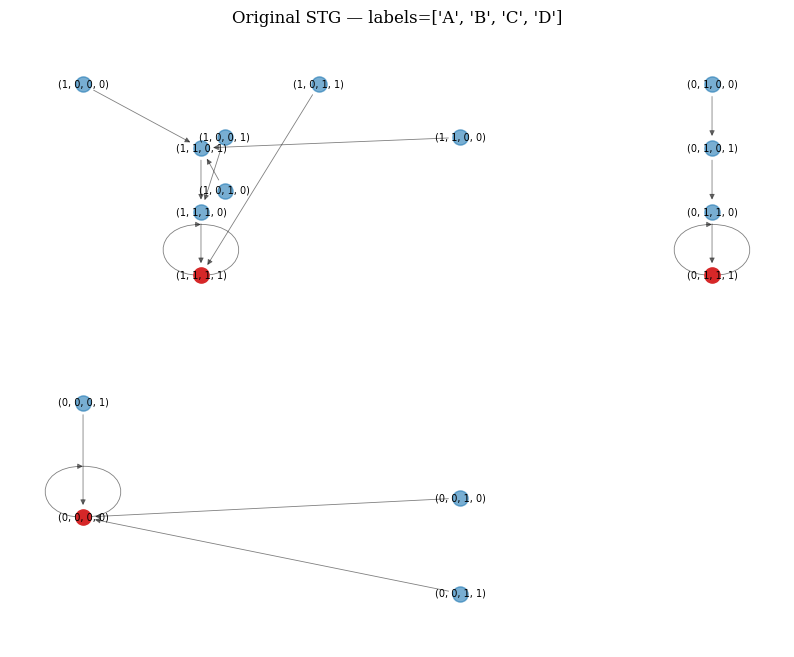

In [8]:
subset = ["A","B", "C", "D"] # or ['NANOG','OCT4','SOX2','KLF4','Y']
Gs_sub = build_stg_from_res(res_orig, G, label="subset", subset=subset)
hi_sub = attractor_node_labels(res_orig, G, label="subset", subset=subset)
plot_stg(Gs_sub, highlight=hi_sub, title=f"Original STG — labels={subset}")


In [9]:
control = {"A": 1}  # NOTE: double-check names!

# 4) Run basin calc with merged params
res_ctrl = basin.basin_under_transient_control(
    params, G, control_dict=control,
    max_steps=1000,
    x0_mode="auto",
    seed=42,
    record_stg=False,
    pseudo_nodes=['Y']      # also double-check names exist
)

print_full_basins(res_ctrl)
print()
print_pseudo_basins(res_ctrl)


Full attractors (with basin sizes), total sims = 16
  λ=1  basin=16/16  (prob=1.000)
    {'A': 1, 'B': 1, 'C': 1, 'D': 1, 'Y': 1}

Pseudo-attractors (with basin sizes), total sims = 16
  λ=1  basin=16/16  (prob=1.000)
    {'Y': 1}


In [10]:
import compare_basins as cb

#cb.compare_basin_overlap_fixed(res_orig, res_ctrl, G, pseudo_nodes=['NANOG','OCT4','SOX2','KLF4','Y'])
cb.check_pattern_occupancy_fixed(res_orig, res_ctrl, G, {'Y': 1})



🎯 Pattern {'Y': 1} (evaluated over FULL attractors):
  Matching original attractors: 2 (cover 24/32 = 0.750)
  Occupied under control: 1 (cover 16/32 = 0.500)
  Not reached under control: 1 (cover 8/32 = 0.250)

  Reached (examples):
   λ=1 basin=16 prob=0.500 codes=(31,)
     {'A': 1, 'B': 1, 'C': 1, 'D': 1, 'Y': 1}


  Unreached (examples):
   λ=1 basin=8 prob=0.250 codes=(30,)
     {'A': 0, 'B': 1, 'C': 1, 'D': 1, 'Y': 1}



In [11]:
import sys
sys.path.append("src")

from copy import deepcopy
import util
from other_methods import simulate, net
import basin

# 1) Load + merge
params_file = "input/params.yaml"
params_base = util.load_yaml(params_file)

params2 = deepcopy(params_base)
params2["verbose_poke"] = True
params2["use_mutations"] = True
params2["network_file"] = "./input/networks/test/14.bnet"
params2["mutations"] = {"C": 1,"D": 1}

sim_params = simulate.get_sim_params(params2)   # adds clause_bin_size, num_samples, time_steps, update_rule, etc.
params = {**sim_params, **params2}              # merged → use THIS everywhere below

# 2) Build/prepare Net with merged params (NOT params2)
G = net.Net(params)
G.prepare(params)

# 3) Define transient control (names must exist in G.nodeNames)
control = {}  # NOTE: double-check names!

# 4) Run basin calc with merged params
res_orig = basin.basin_under_transient_control(
    params, G, control_dict=control,
    max_steps=1000,
    x0_mode="auto",
    seed=42,
    record_stg=True,    # also double-check names exist
)

print_full_basins(res_orig)
print()
print_pseudo_basins(res_orig)

Full attractors (with basin sizes), total sims = 32
  λ=1  basin=16/32  (prob=0.500)
    {'A': 1, 'B': 1, 'C': 1, 'D': 1, 'Y': 1}
  λ=1  basin=8/32  (prob=0.250)
    {'A': 0, 'B': 0, 'C': 1, 'D': 1, 'Y': 1}
  λ=1  basin=8/32  (prob=0.250)
    {'A': 0, 'B': 1, 'C': 1, 'D': 1, 'Y': 1}

No pseudo-attractor basins (pseudo_nodes not set).


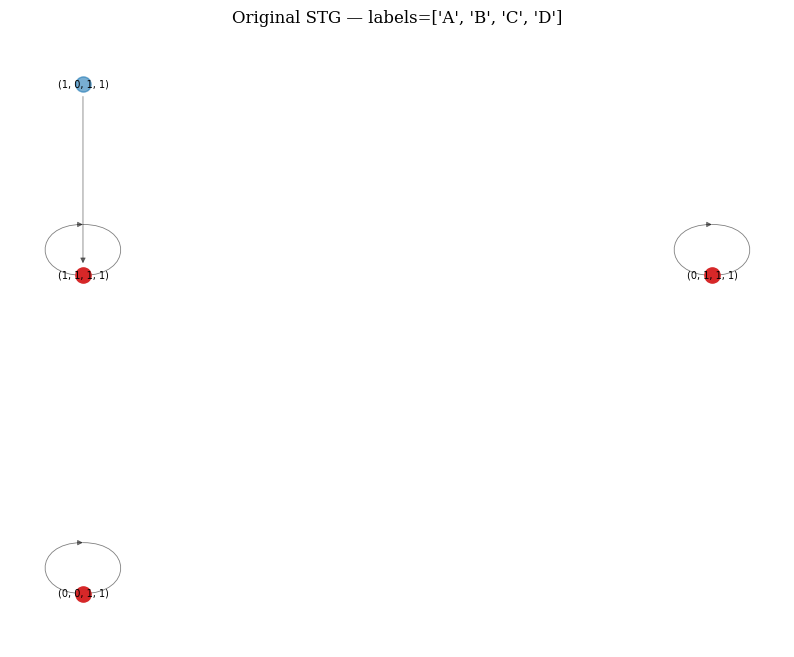

In [12]:
subset = ["A","B", "C", "D"] # or ['NANOG','OCT4','SOX2','KLF4','Y']
Gs_sub = build_stg_from_res(res_orig, G, label="subset", subset=subset)
hi_sub = attractor_node_labels(res_orig, G, label="subset", subset=subset)
plot_stg(Gs_sub, highlight=hi_sub, title=f"Original STG — labels={subset}")


In [13]:
import sys
sys.path.append("src")

from copy import deepcopy
import util
from other_methods import simulate, net
import basin

# 1) Load + merge
params_file = "input/params.yaml"
params_base = util.load_yaml(params_file)

params2 = deepcopy(params_base)
params2["verbose_poke"] = True
params2["use_mutations"] = True
params2["network_file"] = "./input/networks/test/14.bnet"
params2["mutations"] = {"A": 1}

sim_params = simulate.get_sim_params(params2)   # adds clause_bin_size, num_samples, time_steps, update_rule, etc.
params = {**sim_params, **params2}              # merged → use THIS everywhere below

# 2) Build/prepare Net with merged params (NOT params2)
G = net.Net(params)
G.prepare(params)

# 3) Define transient control (names must exist in G.nodeNames)
control = {}  # NOTE: double-check names!

# 4) Run basin calc with merged params
res_orig = basin.basin_under_transient_control(
    params, G, control_dict=control,
    max_steps=1000,
    x0_mode="auto",
    seed=42,
    record_stg=True,    # also double-check names exist
)

print_full_basins(res_orig)
print()
print_pseudo_basins(res_orig)

Full attractors (with basin sizes), total sims = 32
  λ=1  basin=32/32  (prob=1.000)
    {'A': 1, 'B': 1, 'C': 1, 'D': 1, 'Y': 1}

No pseudo-attractor basins (pseudo_nodes not set).


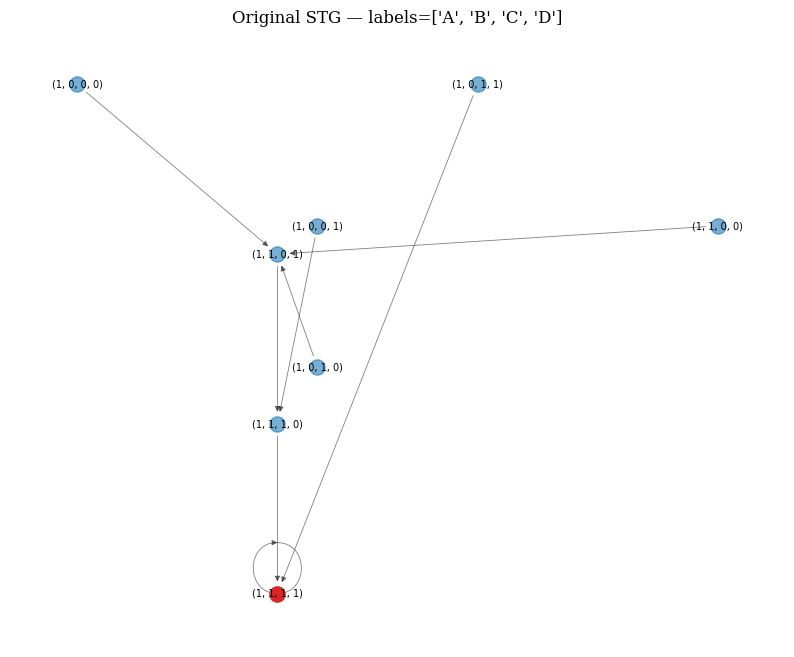

In [14]:
subset = ["A","B", "C", "D"] # or ['NANOG','OCT4','SOX2','KLF4','Y']
Gs_sub = build_stg_from_res(res_orig, G, label="subset", subset=subset)
hi_sub = attractor_node_labels(res_orig, G, label="subset", subset=subset)
plot_stg(Gs_sub, highlight=hi_sub, title=f"Original STG — labels={subset}")
